# Monitoring Chatbots with Langchain, AtlasDB, and Co:Here

One of the hardest things about building a chatbot is monitoring how users are actually interacting with the model. Are users inputting toxic text? Is your bot producing toxic outputs?

In this notebook, we'll show you how to use Langchain, AtlasDB, and Co:Here to monitor your chatbot for toxic content.

## Env Setup

In [ ]:
!pip install langchain

In [ ]:
!pip install cohere

In [ ]:
!pip install datasets

In [ ]:
!pip install --upgrade nomic

# Data Setup

To mock a query stream that gets progressively more unsafe, we are going to use two datasets from Allen AI. 

The first dataset, soda, contians several "normal" chatbot transcripts. The second dataset, prosocial-dialog, contains several "unsafe" transcripts.

We are going to build a data generator that randomly samples a datapoint from one of these datasets.
As time goes on, it will become more likely that the generator selects a "unsafe" datum. This will mock the real world situation where your query stream becomes more unsafe over time.



In [ ]:
import random
from datasets import load_dataset

In [ ]:
def stream_data(T=5000):
  safe = load_dataset('allenai/soda')['train']
  unsafe = iter([e for e in load_dataset('allenai/prosocial-dialog')['train']
                 if e['safety_label'] == '__needs_intervention__'])

  for t in range(T):
    p_unsafe = t/(3*T) #slowly increase toxic content to 33% chance
    is_unsafe = random.uniform(0, 1) <= p_unsafe
    if is_unsafe:
      x = next(unsafe)
      yield 'unsafe', t, x['context'] + ' ' + x['response']
    else:
      x = safe[t]
      yield 'safe', t, x['dialogue'][0]

data = [e for e in stream_data(6000)]
train_data = data[:5000]
test_data = data[5000:]

# Model Setup

Time to build our langchain!
We are going to use AtlasDB by Nomic to store our chat data, and CohereEmbeddings to embed it.

In [ ]:
import time
import numpy as np
from tqdm import tqdm
from pprint import pprint
from langchain.vectorstores import AtlasDB
from langchain.embeddings import CohereEmbeddings

In [ ]:
# Create a CohereEmbeddings object to vectorize our text
COHERE_API_KEY='3vwcW4Gu0m5XWaT5bx4PBJ8IiQ5rT11rSsMijTBu'
ATLAS_API_KEY='HJJiOS5VpjGVTUtNPQKwdGGLIGHzg9XXXQrSwb2rzu5KE'
embedding = CohereEmbeddings(cohere_api_key=COHERE_API_KEY, model='small')

# Create an AtlasDB object to store our vectors
db = AtlasDB(name='test_'+str(time.time()),
             api_key=ATLAS_API_KEY,
             embedding_function=embedding)

Now lets run our simulation. We use the add_texts function of AtlasDB to add texts to the database

In [ ]:
batch_size = 1000
batched_texts = []
batched_metadatas = []

for datum in tqdm(train_data):

  label, t, text = datum[0], datum[1], datum[2]

  #Batch data for faster adds. You can also add data one at a time if you like
  batched_texts.append(text)
  batched_metadatas.append({'label': label, 't': t})

  if len(batched_texts) >= batch_size:
    #Add data to database as it streams
    db.add_texts(texts=batched_texts,
                 metadatas=batched_metadatas,
                 refresh=False) #refresh=False indicates that we would not rebuild the database every time we add a text
    batched_texts = []
    batched_metadatas = []

Once we've added all of our text, we can create an index over our data.
If you add more text after creating your index, you can refresh with `db.project.rebuild_maps()`

For a full list of kwargs to create_index, see:
https://docs.nomic.ai/atlas_api.html#nomic.project.AtlasProject.create_index

In [ ]:
#Build an index of our data
db.create_index(name='MyIndex',
                colorable_fields=['t', 'label'],
                build_topic_model=True,
                topic_label_field='text')

Once the index completes, we can view it inline in our notebook!

In [ ]:
#Wait for the index to build
with db.project.wait_for_project_lock():
    time.sleep(1)

In [ ]:
db.project

Atlas automatically builds a topic model on your data, allowing you to understand what people are talking about with your bot at a glance. 

Check out the bottom left corner of the map. The topics there (e.g. domestic violence, jokes/rape, etc...) indicate that there is unsafe content in your query stream!

You can click on a topic label to filter the map to only things of that topic


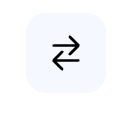
The slider tool can be used to visualize data within certain time ranges. Using it, we can see that our query stream becomes more toxic over time.

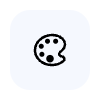
The aesthetic tool can be used to change the colors on the map. Coloring by the label confirms that our map places most of the toxic content in the same region of the map.

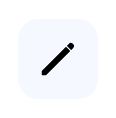

The pencil tool can be used to select regions of the map, which can be bulk labeled

### Getting Topic Information

We can view the topics that AltasDB extracted programatically in our code.

In [ ]:
map = db.project.maps[0]
topic_data = map.get_topic_data() #this is how we view all of the metadata associated with our topics
pprint(topic_data)

Based on this topic information, we can see several clusters of unsafe data we want to flag - things like "stealing", "violence", "addiction".

Furthermore, we see that each entry may have several entries under _topic_depth. The Nomic topic model is hierarchical, and entries with multiple depths trace the path down our topic tree. For instance, 

```
 {'_topic_depth_1': 'You Should Not Do That If You',
  '_topic_depth_2': 'Addiction',
  'depth': 2,
  'topic': 17,
  'topic_description': 'drugs/smoking/doctor/medication/addicted/pills/meds/cocaine/medicine/heroin/sleeping/sugar/quit/take/suddenly',
  'topic_short_description': 'Addiction'},
```

Is a depth 2 topic, whose parent topic is named "You should not do that if you", and whose distinguishing words are "drugs, smoking, doctor, medication, addicted, etc..."



## Using Topics to Filter the Query Stream

By exploring the map, we can see that many of the unsafe topics share the top level label "Don't hurt people." Let's use AtlasDB to build a greylist so we can review detect utterances that may be unsafe.

In [ ]:
# Prep the data from our test set
test_labels = [e[0] for e in test_data]
test_text = [e[2] for e in test_data]
test_embeddings = np.stack(embedding.embed_documents(test_text))

In [ ]:
unsafe_topic = '7' #The topic number of our unsafe topic
batch_size = 100
topic_posteriors = []
for i in range(0, len(test_embeddings), batch_size):
  batch = test_embeddings[i:i+batch_size]
  cur_posteriors = map.vector_search_topics(batch, k=32, depth=1)['topics'] #Use AtlasDB to unfer the topics of new data
  topic_posteriors.extend(cur_posteriors)

predicted_is_unsafe = [max(posterior, key=lambda topic: posterior[topic]) == unsafe_topic
                       for posterior in topic_posteriors]

In [ ]:
#Analyze the results of our classifier on the test data
tp = 0
fp = 0
fn = 0
for i, label in enumerate(test_labels):
  if predicted_is_unsafe[i]:
    if label == 'unsafe':
      tp += 1
    else:
      fp += 1
  else:
    if label == 'unsafe':
      fn += 1

print('Precision: ', tp/(tp+fp))
print('Recall: ', tp/(tp+fn))

Wow! By just using the topics that AtlasDB automatically generated for us, we were able to identify the *unseen* harmful data with a precision of 99% and a recall of 74%. 

To increase these numbers further, we could use the pencil tool to select particular regions, or write more complicated logic over which lower level topics to include.